# Subpopulation Identification in Bladder Cancer Proteomics

### Reproducibility and expected folder structure

This notebook assumes the following relative paths:

- `../data/proteomics.txt` (required)
- `../data/metadata.csv` (optional; used only for bonus exploration)
- `./src/` (required): helper functions imported as `src.bladder_proteomics.*`

## Level 1 – Unsupervised Clustering Analysis

**Course:** Omics for Non-Biologists  
**Group name:** Genomics  

**Group members:**  
- Ke Wang
- Carla Malo
- Marc Nanzer
- Jiayi Ma
- Choekyel Nyungmartsang

Bladder cancer is a heterogeneous disease with patients exhibiting diverse molecular profiles and clinical outcomes.  
In this project, we analyze a proteomics dataset comprising **140 bladder cancer patients** and **3,120 proteins** per patient, with the goal of identifying underlying patient subpopulations.

**Level 1** of the project focuses on:
1. Designing a suitable AI-based clustering pipeline for high-dimensional omics data.
2. Determining the optimal number of patient subpopulations using quantitative metrics and visual evidence.

To address this task, we apply dimensionality reduction using **Principal Component Analysis (PCA)** followed by **KMeans clustering**.  
Clustering quality and stability are evaluated using **silhouette scores**, **elbow analysis**, and **low-dimensional visualizations (PCA and UMAP)**.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2
from sklearn.metrics import pairwise_distances_argmin_min

REQUIRED_FILES = ["../data/proteomics.txt"]
for f in REQUIRED_FILES:
    if not os.path.exists(f):
        raise FileNotFoundError(f"Missing required input file: {f}")

if not os.path.isdir("./src"):
    raise FileNotFoundError(
        "Missing required folder './src'. "
        "Please include the 'src' directory containing 'bladder_proteomics' with the submission."
    )

from src.bladder_proteomics.utils import load_data, validate_data
from src.bladder_proteomics.preprocessing import log1p_transform, zscore_normalize, variance_filter
from src.bladder_proteomics.dimensionality_reduction import apply_pca, pca_elbow, apply_umap, pc_names
from src.bladder_proteomics.clustering import kmeans_cluster
from src.bladder_proteomics.k_selection import elbow_method, silhouette_analysis, calculate_elbow_point
from src.bladder_proteomics.plotting import plot_elbow, plot_silhouette_scores, plot_2d_embedding, plot_cluster_sizes

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.dpi"] = 120

## 1. Data Overview and Preprocessing

**Input files**
- `proteomics.txt`: protein abundance matrix.
- The analysis uses only the proteomics matrix for Level 1.

**Data orientation**
- The file is loaded with `transpose=True`, yielding a **patients × proteins** table (rows are patients, columns are proteins).

**Preprocessing (minimal, decision-driven)**
- Removed 9 duplicated protein features (identical expression profiles across patients) to avoid redundant dimensions in PCA and KMeans.
- `log1p` transform reduces the influence of large values and improves numerical stability.
- Per-protein z-score normalization puts proteins on a comparable scale (important for PCA and KMeans).
- A low-variance filter removes near-constant proteins that contribute little to clustering.
- We then keep the top 20% most variable proteins by coefficient of variation (CV) to focus on informative signals.
- Outliers are detected in PCA space using Mahalanobis distance and excluded from model selection and clustering.

In [2]:
# Load data
df = load_data("../data/proteomics.txt", transpose=True, index_col=0, sep="\t")
df = df.loc[:, ~df.T.duplicated()] # 9 duplicated protein features removed
validate_data(df)

# Basic preprocessing
df = log1p_transform(df)
df = zscore_normalize(df, axis=0)
df, lowvar_mask = variance_filter(df, percentile=10)
print("After low-variance filter:", df.shape)

# Keep top 20% proteins by coefficient of variation (CV)
means = df.mean(axis=0).replace(0, np.nan)
stds = df.std(axis=0)
cv = (stds / means).sort_values(ascending=False)

top_fraction = 0.20
k = int(len(cv) * top_fraction)
df_highinfo = df[cv.index[:k]].copy()
print("After CV feature selection (top 20% proteins):", df_highinfo.shape)


Data shape (samples × features): (140, 3112)
Missing values: 0
Duplicate rows: 0 | Duplicate columns: 0
After low-variance filter: (140, 2932)
After CV feature selection (top 20% proteins): (140, 586)


In [5]:
df_highinfo.head()

Protein_ID,IDH2,A1BG,SH3GLB2,TFRC,NDUFB1,CASP5,NAPRT,CCNA2,UPK3A,NELFA,...,RAP2B,BABAM2,CARM1,TKT,PGAM5,F5,PBXIP1,TMED4,ATP5F1C,BPHL
BC.1,2.777931,0.718019,0.327863,-0.432786,-5.109980,0.810234,1.595560,1.710323,1.536468,-1.143881,...,-0.109595,1.848061,-0.341671,3.627890,-0.464924,2.032159,1.254899,-1.607050,0.988817,3.127535
BC.2,2.607761,1.106558,-1.526188,-0.738672,-4.489658,0.200962,-3.998361,1.609288,1.549575,-2.852106,...,3.595008,0.480231,0.409510,0.232949,-0.116959,0.314697,-2.902585,-2.110864,-1.003529,-2.647564
BC.3,3.921179,0.767078,-1.997325,-0.469413,-6.385238,0.271537,-2.370035,1.693089,1.552037,-4.478160,...,-0.636752,0.906598,0.724398,0.795142,0.391679,2.416548,2.903643,-0.585258,0.591363,-2.227678
BC.4,3.378952,1.050973,-2.938261,-0.476212,-5.672534,-0.916178,-3.323533,1.512257,1.540549,-3.635266,...,-0.135082,0.968800,1.483495,-0.880235,0.564072,-1.421437,-1.254679,-6.148654,-0.248799,-2.726701
BC.5,2.432818,1.356495,0.336016,-0.398640,-0.246006,0.004086,-0.541378,1.710323,1.549160,1.031101,...,3.018905,1.514237,-2.849990,1.404672,-1.074418,-3.329971,2.117427,-1.363301,1.038346,0.350163


In [6]:
# Outlier detection in PCA space using Mahalanobis distance
# Threshold uses chi-square quantile with df = n_PC and confidence level = 0.999
chosen_n_pc_outlier = 12
confidence_level = 0.999

pca_outlier_df, _ = apply_pca(df_highinfo, n_components=chosen_n_pc_outlier, return_model=True)
pca_outlier_df = pc_names(pca_outlier_df)

X = pca_outlier_df.values
mu = X.mean(axis=0)
cov = np.cov(X, rowvar=False)
inv_cov = np.linalg.inv(cov)

mahal_dist = np.array([(x - mu) @ inv_cov @ (x - mu).T for x in X])
threshold = chi2.ppf(confidence_level, df=chosen_n_pc_outlier)

is_outlier = pd.Series(mahal_dist > threshold, index=df_highinfo.index, name="is_outlier")
df_clean = df_highinfo.loc[~is_outlier].copy()
df_outliers = df_highinfo.loc[is_outlier].copy()

print(f"Outliers detected: {is_outlier.sum()} / {len(is_outlier)}")
print("Clean set shape:", df_clean.shape)
print("Outlier set shape:", df_outliers.shape)

Outliers detected: 12 / 140
Clean set shape: (128, 586)
Outlier set shape: (12, 586)


## 2. Dimensionality Reduction Strategy (PCA)

PCA is used for:
- **Dimensionality reduction**: clustering in a lower-dimensional space reduces noise and collinearity.
- **Visualization**: 2D PCA plots provide an interpretable view of structure.
- **Stabilizing KMeans**: KMeans is sensitive in high dimensions; PCA improves conditioning.

We select the number of principal components for clustering using:
- A scree plot (explained variance per component).
- An elbow detector applied to the explained-variance curve.

In [7]:
# Fit PCA on the clean set (for scree + downstream clustering)
pca_full_df, pca_model = apply_pca(df_clean, n_components=20, return_model=True)
pca_full_df = pc_names(pca_full_df)

explained = pca_model.explained_variance_ratio_
elbow_pc = pca_elbow(explained)

print(f"Elbow (explained-variance curve): PC = {elbow_pc}")

Elbow (explained-variance curve): PC = 4


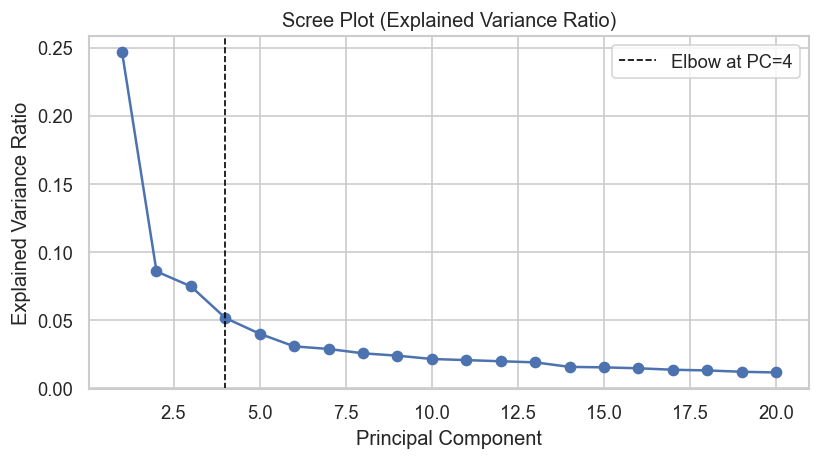

In [8]:
# Scree plot
plt.figure(figsize=(7, 4))
plt.plot(range(1, len(explained) + 1), explained, marker="o")
plt.axvline(elbow_pc, linestyle="--", color="black", linewidth=1, label=f"Elbow at PC={elbow_pc}")
plt.title("Scree Plot (Explained Variance Ratio)")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.legend()
plt.tight_layout()
plt.show()

*Figure: Scree plot of explained variance ratios on the clean patient set. The primary elbow occurs at PC=4, indicating diminishing returns beyond the first few components.*

## 3. Clustering Methodology

We cluster patients using **KMeans** in PCA space.

- **Why KMeans:** simple, interpretable, and appropriate for identifying compact groups in a continuous embedding.
- **Distance metric:** KMeans minimizes within-cluster sum of squares under **Euclidean distance**, which is appropriate after z-scoring.
- **Stability considerations:** clustering is performed on a reduced PCA representation to reduce noise sensitivity.

In [9]:
# Choose PCA dimension for clustering
# Based on the scree elbow at PC=4 and stable behavior around PC≈5, we use n_pc=5 for the main pipeline.
n_pc = 5
X_pca = pca_full_df.iloc[:, :n_pc].copy()
X_pca.shape

(128, 5)

## 4. Determining the Number of Clusters

We select the number of clusters **K** using:

- **Elbow method** (inertia): gives a coarse candidate range where additional clusters provide diminishing returns.
- **Silhouette analysis**: prioritizes partitions with clear separation in the PCA space.

In this dataset, the elbow criterion suggests a larger K, but the silhouette score peaks at **K = 2**.  
We therefore prioritize **silhouette separation** and **interpretability**, and treat larger K values as sensitivity checks to verify that we are not over-fragmenting the cohort.

Elbow-suggested K (inertia): 6
Best K by silhouette: 2  (score=0.463)


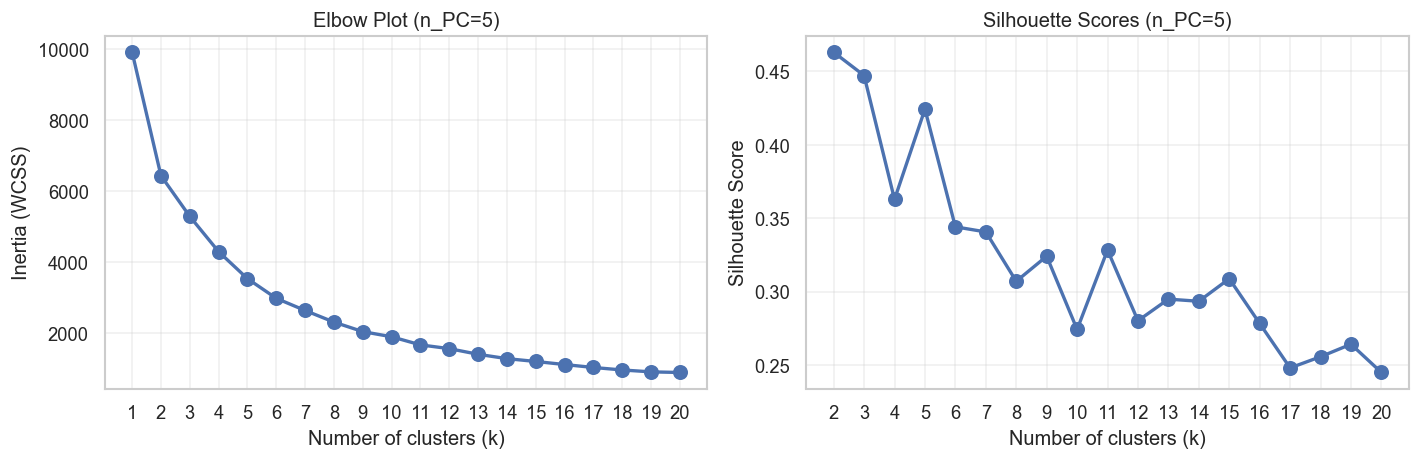

In [10]:
k_max = 20

sil_scores = silhouette_analysis(X_pca, k_range=range(2, k_max + 1))
inertias = elbow_method(X_pca, k_range=range(1, k_max + 1))
elbow_k = calculate_elbow_point(inertias)

best_k_sil = max(sil_scores, key=sil_scores.get)

print(f"Elbow-suggested K (inertia): {elbow_k}")
print(f"Best K by silhouette: {best_k_sil}  (score={sil_scores[best_k_sil]:.3f})")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_elbow(inertias, ax=axes[0], title=f"Elbow Plot (n_PC={n_pc})")
plot_silhouette_scores(sil_scores, ax=axes[1], title=f"Silhouette Scores (n_PC={n_pc})")
plt.tight_layout()
plt.show()

*Figure: Elbow plot (left) and silhouette scores (right) for KMeans on the first 5 PCs. The elbow provides a coarse candidate range, while the silhouette curve highlights the most separated partition.*

### Interpreting elbow vs silhouette

The elbow curve (inertia) decreases steadily as K increases and suggests diminishing returns only at a larger K (around 5 in our run). This is common in high-dimensional omics data, because adding clusters almost always reduces within-cluster variance.

In contrast, the silhouette score directly measures separation between clusters and shows its clearest maximum at **K = 2**, indicating that the 2-cluster solution provides the most distinct partition in the current representation.

We therefore select **K = 2** as the final Level 1 answer. Larger K values mainly subdivide the data into smaller, less stable groups and are better treated as potential finer stratification for follow-up analysis rather than the primary subpopulation count.

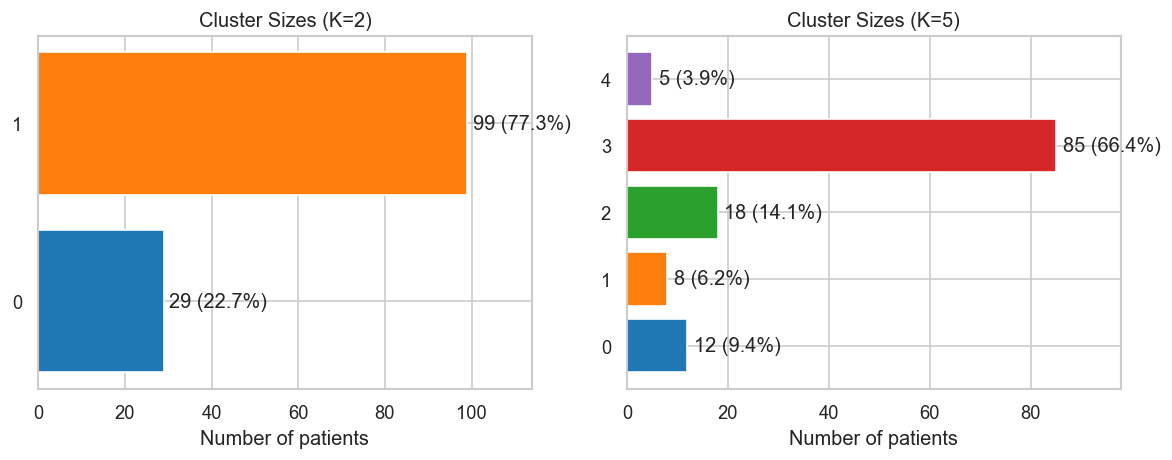

In [11]:
# Compare cluster size fragmentation for K=2 vs K=5 (used as a sensitivity check in the original exploration)
k_compare = [2, 5]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, k0 in zip(axes, k_compare):
    labels0 = pd.Series(kmeans_cluster(X_pca, n_clusters=k0, align_labels=True), index=X_pca.index, name="label")
    plot_cluster_sizes(labels0, title=f"Cluster Sizes (K={k0})", ax=ax)

plt.tight_layout()
plt.show()

*Figure: Cluster size distributions for K=2 and K=5 on the same PCA embedding (n_PC=5). K=5 produces smaller, more fragmented groups, while K=2 yields a clearer coarse partition.*

## 5. Cluster Characterization and Visualization

We fit KMeans using the selected K and visualize clusters in:
- **PCA (PC1 vs PC2)** for interpretability.
- **Cluster size bar plot** to ensure the solution is not dominated by tiny clusters.

Outliers are excluded from the fitting step and handled separately (see Supplementary Analyses).

In [12]:
# Final clustering on clean set
best_k = 2
labels_clean = pd.Series(
    kmeans_cluster(X_pca, n_clusters=best_k, align_labels=True),
    index=X_pca.index,
    name="label",
)

labels_clean.value_counts().sort_index()

label
0    29
1    99
Name: count, dtype: int64

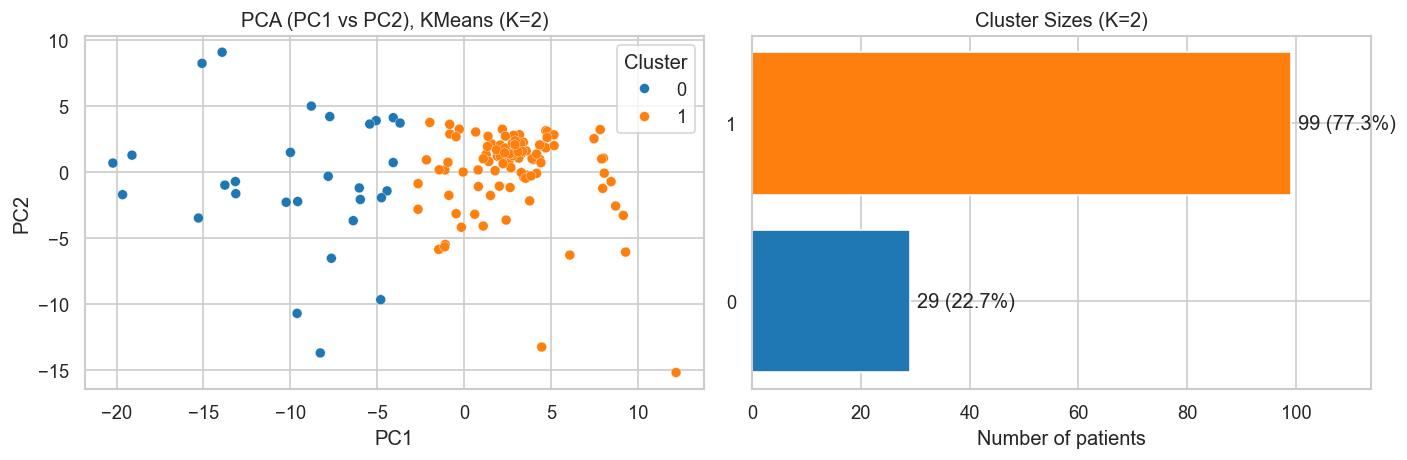

In [13]:
# PCA visualization (PC1 vs PC2) on clean set
pca2 = X_pca.iloc[:, :2].copy()
pca2 = pc_names(pca2)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_2d_embedding(pca2, labels_clean, title=f"PCA (PC1 vs PC2), KMeans (K={best_k})", ax=axes[0])
plot_cluster_sizes(labels_clean, title=f"Cluster Sizes (K={best_k})", ax=axes[1])
plt.tight_layout()
plt.show()

*Figure: PCA scatter (left) and cluster sizes (right) for the final KMeans solution on clean patients. The plot shows the separation structure used to support the chosen subpopulation count and the corresponding group sizes.*

**Note:** The final partition is imbalanced (~30 vs ~100 patients), which is consistent with a potentially smaller subgroup rather than equally sized subpopulations.

## 6. Final Choice of Patient Subpopulations

**Final choice:** **K = 2** patient subpopulations.

This choice is supported by the silhouette analysis, which consistently favors K=2 as the most separated partition, and inspection of cluster sizes, where larger K values mainly subdivide tails into small, fragmented groups rather than revealing equally strong additional subpopulations. The result is a clear coarse stratification suitable as a stable starting point for downstream characterization in Level 2.

## 7. Supplementary Analyses

This section contains sensitivity checks that are informative but not required for the main decision:
- Outlier-curve inspection used to select `n_PC=12` for Mahalanobis-based outlier detection.
- Stability of the K=2 structure across alternative PCA dimensions.
- UMAP visualization using the same cluster labels (no change to the main pipeline).
- Outlier assignment to the nearest clean-cluster centroid (used only to produce labels for all patients).

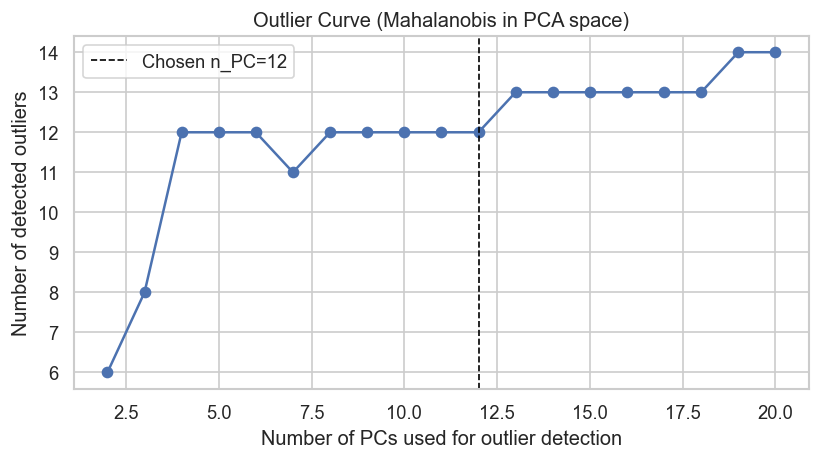

In [14]:
# (A) Outlier curve: outlier count as a function of PCA dimension
n_pc_grid = list(range(2, 21))
outlier_counts = {}

for npc in n_pc_grid:
    tmp_df, _ = apply_pca(df_highinfo, n_components=npc, return_model=True)
    tmp_df = pc_names(tmp_df)
    Xt = tmp_df.values

    mu_t = Xt.mean(axis=0)
    cov_t = np.cov(Xt, rowvar=False)
    inv_cov_t = np.linalg.inv(cov_t)

    d_t = np.array([(x - mu_t) @ inv_cov_t @ (x - mu_t).T for x in Xt])
    thr_t = chi2.ppf(confidence_level, df=npc)
    outlier_counts[npc] = int((d_t > thr_t).sum())

plt.figure(figsize=(7, 4))
plt.plot(list(outlier_counts.keys()), list(outlier_counts.values()), marker="o")
plt.axvline(chosen_n_pc_outlier, linestyle="--", color="black", linewidth=1, label=f"Chosen n_PC={chosen_n_pc_outlier}")
plt.title("Outlier Curve (Mahalanobis in PCA space)")
plt.xlabel("Number of PCs used for outlier detection")
plt.ylabel("Number of detected outliers")
plt.legend()
plt.tight_layout()
plt.show()

*Figure: Outlier count across PCA dimensions for Mahalanobis distance thresholding. A stable plateau supports using n_PC=12 for robust outlier detection before clustering.*

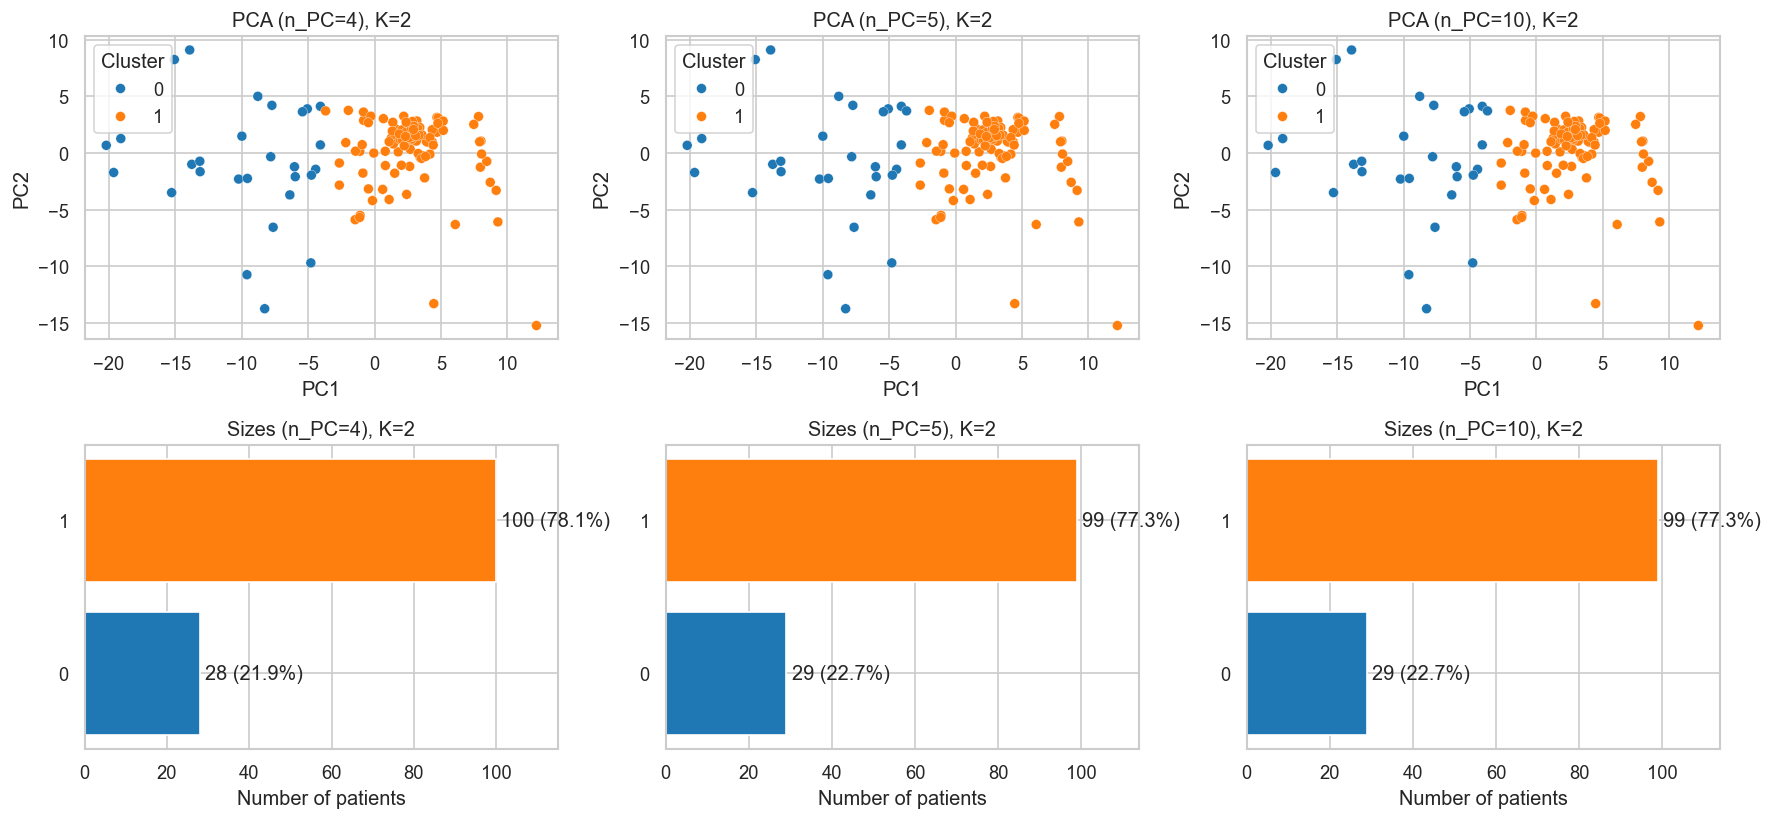

In [15]:
# (B) PCA-dimension stability check for the final K
pc_list = [4, 5, 10]

fig, axes = plt.subplots(2, len(pc_list), figsize=(5 * len(pc_list), 7))

for j, npc in enumerate(pc_list):
    Xj = pca_full_df.iloc[:, :npc].copy()
    labels_j = pd.Series(kmeans_cluster(Xj, n_clusters=best_k, align_labels=True), index=Xj.index, name="label")

    # PCA plot uses the first two PCs available in Xj
    emb2 = pc_names(Xj.iloc[:, :2].copy())
    plot_2d_embedding(emb2, labels_j, title=f"PCA (n_PC={npc}), K={best_k}", ax=axes[0, j])
    plot_cluster_sizes(labels_j, title=f"Sizes (n_PC={npc}), K={best_k}", ax=axes[1, j])

plt.tight_layout()
plt.show()

*Figure: Sensitivity of the K=2 partition to the number of retained PCs. The solution remains qualitatively consistent across multiple PCA dimensions, supporting robustness.*

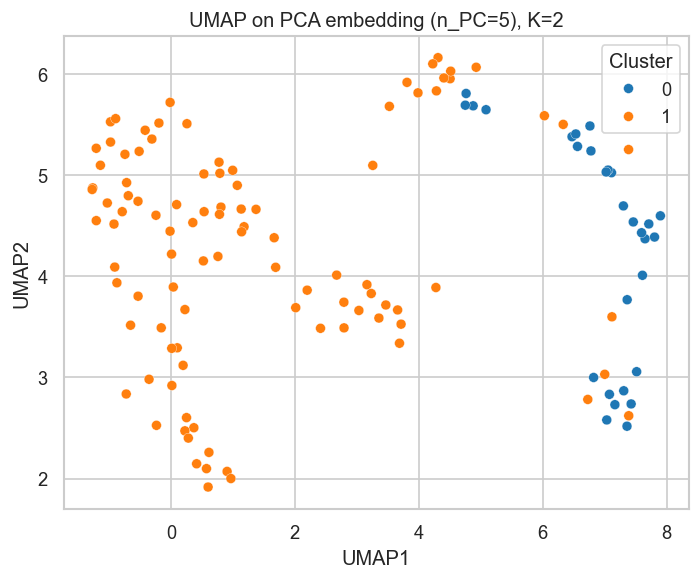

In [16]:
# (C) UMAP visualization using the main PCA embedding (n_PC=5)
umap_df = apply_umap(X_pca, n_components=2)
umap_df = umap_df.copy()
umap_df.columns = ["UMAP1", "UMAP2"]

plt.figure(figsize=(6, 5))
ax = plot_2d_embedding(umap_df, labels_clean, title=f"UMAP on PCA embedding (n_PC={n_pc}), K={best_k}")
plt.tight_layout()
plt.show()

*Figure: UMAP visualization of patients based on the same PCA embedding used for clustering. The geometry is consistent with a dominant coarse separation captured by K=2.*

In [17]:
# (D) Assign outliers to the nearest clean-cluster centroid (Euclidean) and save labels for all patients
# Clustering is fit only on the clean set; outliers are assigned post hoc.

# centroids in PCA space (clean set)
unique_labels = np.sort(labels_clean.unique())
centroids = np.vstack([X_pca.loc[labels_clean == lab].mean(axis=0).values for lab in unique_labels])

# PCA representation of outliers (same dimensionality as clustering)
pca_out = apply_pca(df_outliers, n_components=n_pc, return_model=False)
pca_out = pc_names(pca_out)

nearest_idx, _ = pairwise_distances_argmin_min(pca_out.values, centroids, metric="euclidean")
labels_out = pd.Series(unique_labels[nearest_idx], index=df_outliers.index, name="label")

# final label table for Level 2
labels_all = pd.concat([labels_clean, labels_out]).to_frame()
labels_all.index.name = "Patient_ID"

labels_all.to_csv("../data/cluster_labels.csv")
print("Saved: ../data/cluster_labels.csv")
print("Label counts (all patients, including outliers):")
labels_all["label"].value_counts().sort_index()

Saved: ../data/cluster_labels.csv
Label counts (all patients, including outliers):


label
0     34
1    106
Name: count, dtype: int64

## 8. Conclusion

We built a clean clustering pipeline for identifying patient subpopulations from proteomics data.  
After minimal preprocessing and feature selection, we used PCA to obtain a stable low-dimensional representation.  
KMeans clustering was evaluated using elbow and silhouette criteria, supported by cluster-size inspection.  
The final result identifies **2 patient subpopulations (K=2)** as the most stable and interpretable partition.  
Cluster labels were saved to `../data/cluster_labels.csv`.  
This completes Level 1 and provides inputs for Level 2 analyses focused on identifying proteins that distinguish the subpopulations.